# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [homework page](https://comp150dl.github.io/hw/) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [2]:
import random
import numpy as np
from hw1.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [3]:
from hw1.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
  # Load the raw CIFAR-10 data
  cifar10_dir = 'datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # Subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]

  return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each row is the concatenation of all feature vectors for a single image.

In [4]:
from hw1.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [5]:
# Use the validation set to tune the learning rate and regularization strength

from hw1.classifiers.linear_classifier import LinearSVM

#learning_rates = [1e-3, 5e-2]
# regularization_strengths = [1e5, 5e4]
# [8e-8][1e1] 41.9
# [8e-8][1e5] 42.5
learning_rates = [1e-8,2e-8,3e-8]
regularization_strengths = [1e5,2e5,3e5]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train_feats,y_train,lr, reg, num_iters = 3000, 
                  batch_size = 200)
        y_train_pred = svm.predict(X_train_feats)
        train_acc = np.mean(y_train_pred == y_train)
        y_val_pred = svm.predict(X_val_feats)
        val_acc = np.mean(y_val_pred == y_val)
        results[lr, reg] = (train_acc, val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm


################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

lr 1.000000e-08 reg 1.000000e+05 train accuracy: 0.127878 val accuracy: 0.117000
lr 1.000000e-08 reg 2.000000e+05 train accuracy: 0.279837 val accuracy: 0.310000
lr 1.000000e-08 reg 3.000000e+05 train accuracy: 0.415020 val accuracy: 0.416000
lr 2.000000e-08 reg 1.000000e+05 train accuracy: 0.355571 val accuracy: 0.352000
lr 2.000000e-08 reg 2.000000e+05 train accuracy: 0.415939 val accuracy: 0.415000
lr 2.000000e-08 reg 3.000000e+05 train accuracy: 0.414122 val accuracy: 0.426000
lr 3.000000e-08 reg 1.000000e+05 train accuracy: 0.412061 val accuracy: 0.421000
lr 3.000000e-08 reg 2.000000e+05 train accuracy: 0.412204 val accuracy: 0.413000
lr 3.000000e-08 reg 3.000000e+05 train accuracy: 0.412694 val accuracy: 0.424000
best validation accuracy achieved during cross-validation: 0.426000


In [6]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print test_accuracy

0.424


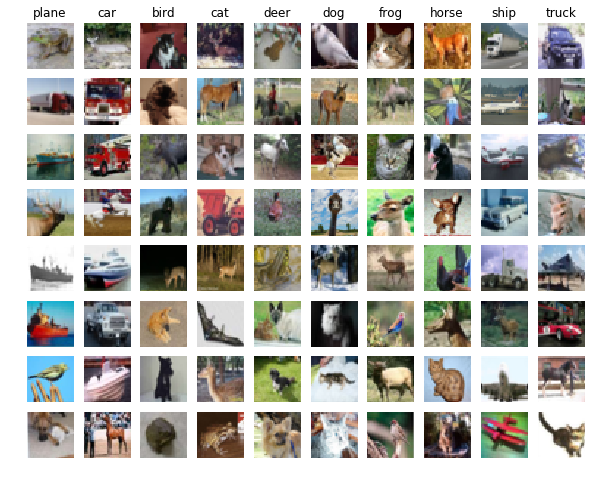

In [7]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Please characterize the misclassifications you observe. What model failures are causing these misclassifications?

#### Answers:
When extracting features, we form our final feature vector for each image by concatenating the HOG and color histogram feature vectors. HOG capture the texture of the image while ignoring color information, so for example plane, ship with similar texture can be easily misclassified. The color histogram represents the color of the input image while ignoring texture, so for example, deer, horse and other animal with similar colors can be misclassified.

## Train 1 vs All SVMs on features
We will compare off-the-shelf "1 vs. All" linear SVMs to the multiclass SVM developed earlier in the assignment. Learn more about scikit-learn's off the shelf svms in the [the sklearn API](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html).

In [9]:
# Use the validation set to tune the learning rate and regularization strength
from sklearn.svm import LinearSVC

classes = 10
# Dictionary of classifiers. One linear SVM should be trained for every class. 
classifiers = {}
train_predictions = np.zeros((len(y_train), classes))
val_predictions = np.zeros((len(y_val), classes))
################################################################################
# TODO:                                                                        #
# Train a 1 vs. All SVM for each CIFAR-10 class. Positive training examples    #
# will come from the same class, and negative examples will come from all      # 
# other classes. Choose the predicted class by selecting the class whose       #
# individual prediction was the most. You could make this a better comparison  #
# by passing the predicted values through a sigmoid function, but that is      #
# optional. To create the training labels, students may want to use the        #
# np.where() function to select the rows corresponding to a given class from   #
# y_train.                                                                     #
################################################################################
for i in range(classes):
    y = np.array(np.zeros(len(y_train)))
    index = np.where(y_train == i)
    y[index] = 1
    SVC = LinearSVC()
    SVC.fit(X_train_feats, y)
    pred_train_val = SVC.decision_function(X_train_feats)
    pred_train_sig_val = 1.0 / (1 + np.exp(np.dot(-1, pred_train_val)))
    train_predictions[:,i] = pred_train_sig_val
    #train_predictions[:,i] = SVC.decision_function(X_train_feats)
    #val_predictions[:,i] = SVC.decision_function(X_val_feats)
    pred_val_val = SVC.decision_function(X_val_feats)
    pred_val_sig_val = 1.0 / (1 + np.exp(np.dot(-1, pred_val_val)))
    val_predictions[:,i] = pred_val_sig_val
    classifiers[i] = SVC
    



################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Max of all classifier results.
y_train_pred = np.argmax(train_predictions, axis=1)
train_acc = np.mean(y_train == y_train_pred)
print 'training accuracy over all classes: %f' % (train_acc)
y_val_pred = np.argmax(val_predictions, axis=1)
val_acc = np.mean(y_val == y_val_pred)
print 'validation accuracy over all classes: %f' % (val_acc)

training accuracy over all classes: 0.508939
validation accuracy over all classes: 0.506000


In [10]:
# Evaluate your trained 1 vs All SVMs on the test set
test_predictions = np.zeros((len(y_test), classes))
for cls in range(classes):
    test_predictions[:,cls] = classifiers[cls].predict(X_test_feats)
y_test_pred = np.argmax(test_predictions, axis=1)
test_accuracy = np.mean(y_test == y_test_pred)
print test_accuracy

0.245


# Bonus: Improve Test Accuracy
Make the outputs of the individual 1 vs. All SVMs more directly comparable or train the classifiers with a non-linear kernel. Any improvement over 25% test accuracy will receive 1 point bonus for every 5 points of increase in test accuracy. 

Nothing classified as bird
Nothing classified as cat
Nothing classified as deer
Nothing classified as dog
Nothing classified as horse
Nothing classified as truck


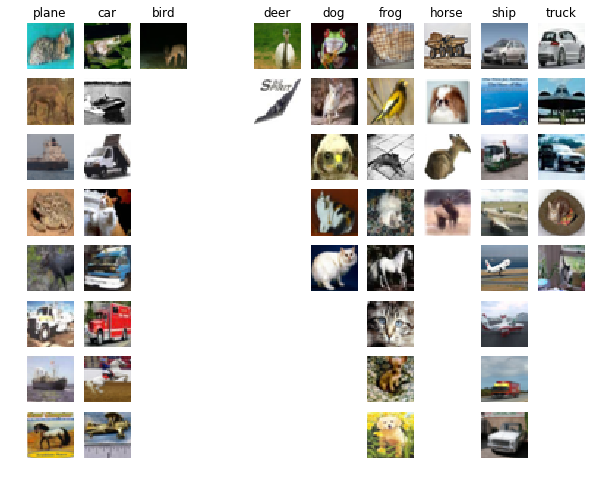

In [11]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    try:
        idxs = np.random.choice(idxs, examples_per_class, replace=False)
    except:
        print 'Nothing classified as {}'.format(classes[cls])
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 2:
What were major differences in the failures of the Multiclass SVM and set of 10 1 vs All SVMs?

1 vs All SVMs train one class every time, it's sensitive to imbalanced dataset, and Multiclass SVM train multiclass
examples, it's not sensitive to imbalanced data. From visualization above, we can see that some class doesn't include
any image via 1 vs All SVMs.


## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [12]:
print X_train_feats.shape

(49000, 155)


In [61]:
from hw1.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None
learning_rates = [1e-1, 2e-1, 3e-1,4e-1]
regularization_strengths = [1e-5,2e-5,3e-5,4e-5]

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
best_val = -1
results = {}
for lr in learning_rates:
    for re in regularization_strengths:
        net.train(X_train_feats, y_train, X_val_feats, y_val,learning_rate = lr,
                 reg = re, num_iters = 200)
        y_train_acc = np.mean(net.predict(X_train_feats) == y_train)
        y_val_acc = np.mean(net.predict(X_val_feats) == y_val)
        results[(lr, re)] = (y_train_acc, y_val_acc)
        if y_val_acc > best_val:
            best_net = net
            best_val = y_val_acc
        
# print results
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

        
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

lr 1.000000e-01 reg 1.000000e-05 train accuracy: 0.208327 val accuracy: 0.216000
lr 1.000000e-01 reg 2.000000e-05 train accuracy: 0.418959 val accuracy: 0.407000
lr 1.000000e-01 reg 3.000000e-05 train accuracy: 0.484735 val accuracy: 0.480000
lr 1.000000e-01 reg 4.000000e-05 train accuracy: 0.511612 val accuracy: 0.511000
lr 2.000000e-01 reg 1.000000e-05 train accuracy: 0.532469 val accuracy: 0.507000
lr 2.000000e-01 reg 2.000000e-05 train accuracy: 0.546837 val accuracy: 0.521000
lr 2.000000e-01 reg 3.000000e-05 train accuracy: 0.562184 val accuracy: 0.551000
lr 2.000000e-01 reg 4.000000e-05 train accuracy: 0.577531 val accuracy: 0.535000
lr 3.000000e-01 reg 1.000000e-05 train accuracy: 0.597878 val accuracy: 0.555000
lr 3.000000e-01 reg 2.000000e-05 train accuracy: 0.620061 val accuracy: 0.570000
lr 3.000000e-01 reg 3.000000e-05 train accuracy: 0.636796 val accuracy: 0.581000
lr 3.000000e-01 reg 4.000000e-05 train accuracy: 0.654122 val accuracy: 0.594000
lr 4.000000e-01 reg 1.000000

In [62]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print test_acc

0.578


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!